In [1]:
class IndexTracker(object):
    def __init__(self, ax, X):
        self.ax = ax
        ax.set_title('use scroll wheel to navigate images')

        self.X = X
        rows, cols, self.slices = X.shape
        self.ind = self.slices//2

        self.im = ax.imshow(self.X[:, :, self.ind])
        self.update()

    def onscroll(self, event):
        print("%s %s" % (event.button, event.step))
        if event.button == 'up':
            self.ind = (self.ind + 1) % self.slices
        else:
            self.ind = (self.ind - 1) % self.slices
        self.update()

    def update(self):
        self.im.set_data(self.X[:, :, self.ind])
        #ax.set_ylabel('slice %s' % self.ind)
        self.im.axes.figure.canvas.draw()

def sh(im):
    plt.figure()
    plt.imshow(im)
def s(ar):
    print(ar.shape)
def pl(ar):
    plt.figure()
    plt.plot(ar)
def scroll(im):
    
    fig, ax = plt.subplots(1, 1)

    tracker = IndexTracker(ax, im)

    fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
    plt.show()

In [1]:
%pylab nbagg
%load_ext autoreload

%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [5]:
import sys
import os
import tigre
from scipy.signal import fftconvolve

sys.path.insert(0,'../xpecgen')

import xpecgen as xg

dose = 1

# phan_map_hard =  ['air','water','Spongiosa_Bone_ICRP','G4_BONE_COMPACT_ICRU',
#              'G4_BONE_CORTICAL_ICRP','C4_Vertebra_ICRP','D6_Vertebra_ICRP','G4_B-100_BONE']

phan_map_hard =  ['air','water','water','water',
             'water','water','water','water']

spectrum_files = ['Al_spectrum_25', 'C_spectrum_6', 'Al_spectrum_6', 'C_spectrum_25', 'W_spectrum_6', 'W_spectrum_25']

dets = ['CWO']#,'CuGOS_lowres']

phan_maps = [phan_map_hard]#,phan_map_soft]

angles = np.linspace(0,2*np.pi,90)

res = []

original_energies_keV = np.array([30, 40, 50 ,60, 70, 80 ,90 ,100 ,300 ,500 ,700, 900, 1000 ,2000 ,4000 ,6000])


angles = np.linspace(0,2*pi,360)

geo = 'catphan_low_contrast_512'

phantom = xg.Catphan_515()

In [6]:
phantom.phantom = np.zeros([10,1024,1024]) #

In [7]:
for phan_map in phan_maps:
    for spectrum_file in spectrum_files:
        for det in dets:
            s = xg.Spectrum()

            energies = []
            fluence = []

            with open(os.path.join(xg.data_path, "MV_spectra", f'{spectrum_file}.txt')) as f:
                for line in f:
                    energies.append(float(line.split()[0]))
                    fluence.append(float(line.split()[1]))
            
            # Check if MV

            s.x = np.array(energies)*1000  # to keV
            s.y = np.array(fluence)

            spectrum = xg.Spectrum()

            spectrum.x = energies
            spectrum.y = fluence

            dump_files = os.path.join(
                xg.data_path, "Detectors", det, '*phsp.npy')
            energy_deposition_file = os.path.join(
                xg.data_path, "Detectors", det, 'EnergyDeposition.npy')

            kernel, kernels = xg.get_kernel(
                                    s, dump_files, energy_deposition_file)

            energy_deposition_file = os.path.join(
                xg.data_path, "Detectors", det, 'EnergyDeposition.npy')
            energies = s.x
            fluence = s.y
            deposition_efficiency_file = energy_deposition_file

            noise = xg.update_fluence(spectrum_file,dose)

            res.append(xg.return_projs(phantom.phantom,kernel,
                                       energies,fluence,angles,phantom.geomet,
                                       deposition_efficiency_file=deposition_efficiency_file
                                       ,phantom_mapping = phan_map,
                                       scaling=noise,
                                      dose=dose))

#             img_xg = tigre.algorithms.FDK(
#                 np.transpose(np.array(projs_xg[0]),[0,2,1]), phantom.geomet,angles)

#             res.append([[phan_map,spectrum_file,det],phantom.analyse_515(img_xg[5])])

AttributeError: module 'xpecgen' has no attribute 'get_kernel'

In [8]:
def create_circular_mask(x, y, r, index, image):
    
    h,w = image.shape
    
    center = [x*int(w/2)/8 + int(w/2),y*int(h/2)/8 + int(h/2)]

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if r is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= r*int(w/2)/8
    
    
    image[mask] = index
    
def create_block(x, y, r, index,n, image):

    h,w = im.shape

    center = np.round([x*int(w/2)/8 + int(w/2),y*int(h/2)/8 + int(h/2)]).astype(int)

    len = 50
    g = r

    plus = int(center[0] + int((n-1)*g/2))
    minus = int(center[1] - int((n-1)*g/2))

    for ii in range(center[0], center[0] + int(2*g)*n, int(2*g)):

        im[center[1]:center[1]+len,ii:ii+g] = index


im = np.zeros([1024,1024])
#im = np.zeros([256,256])
ii = 1

# CTMAT(x) formel=H2O dichte=x
LEN = 100

A0  = 87.7082*np.pi/180
A1 = 108.3346*np.pi/180
A2 = 126.6693*np.pi/180
A3 = 142.7121*np.pi/180
A4 = 156.4631*np.pi/180
A5 = 167.9223*np.pi/180
A6 = 177.0896*np.pi/180
A7 = 183.9651*np.pi/180
A8 = 188.5487*np.pi/180

B0 = 110.6265*np.pi/180
B1 = 142.7121*np.pi/180
B2 = 165.6304*np.pi/180
B3 = 179.3814*np.pi/180

# Phantom 
# ++++ module body ++++++++++++++++++++++++++++++++++++++++++++++++++ */                        
create_circular_mask(x= 0.000,  y= 0.000,  r=8.0, index = ii, image = im)

ii += 1

create_block(x=-3, y = -4, r = 30, n = 2, index = ii, image = im)

# ++++ supra-slice 1.0% targets +++++++++++++++++++++++++++++++++++++++ */
create_block(x= -3,  y= 2,  r=1, n=20, index = ii, image = im)
create_block(x= -1,  y= 2,  r=2, n=16, index = ii, image = im)
create_block(x= 1,  y= 2,  r=3, n=10, index = ii, image = im)
create_block(x= 3,  y= 2,  r=4, n=10, index = ii, image = im)

# ++++ supra-slice 0.3% targets +++++++++++++++++++++++++++++++++++++++ */
create_block(x= -3,  y= 0,  r=5, n=6, index = ii, image = im)
create_block(x= -1,  y= 0,  r=6, n=6, index = ii, image = im)
create_block(x=1,  y= 0,  r=7, n=5, index = ii, image = im)
create_block(x= 3,  y= 0,  r=8, n=4, index = ii, image = im)


# ++++ supra-slice 1% targets +++++++++++++++++++++++++++++++++++++++ */
create_block(x= -3,  y= -2,  r=9, n=4, index = ii, image = im)
create_block(x= -1,  y= -2, r=10, n=4, index = ii, image = im)
create_block(x= 1,  y= -2,  r=11, n=3, index = ii, image = im)
create_block(x= 3,  y= -2,  r=14, n=2, index = ii, image = im)


<IPython.core.display.Javascript object>


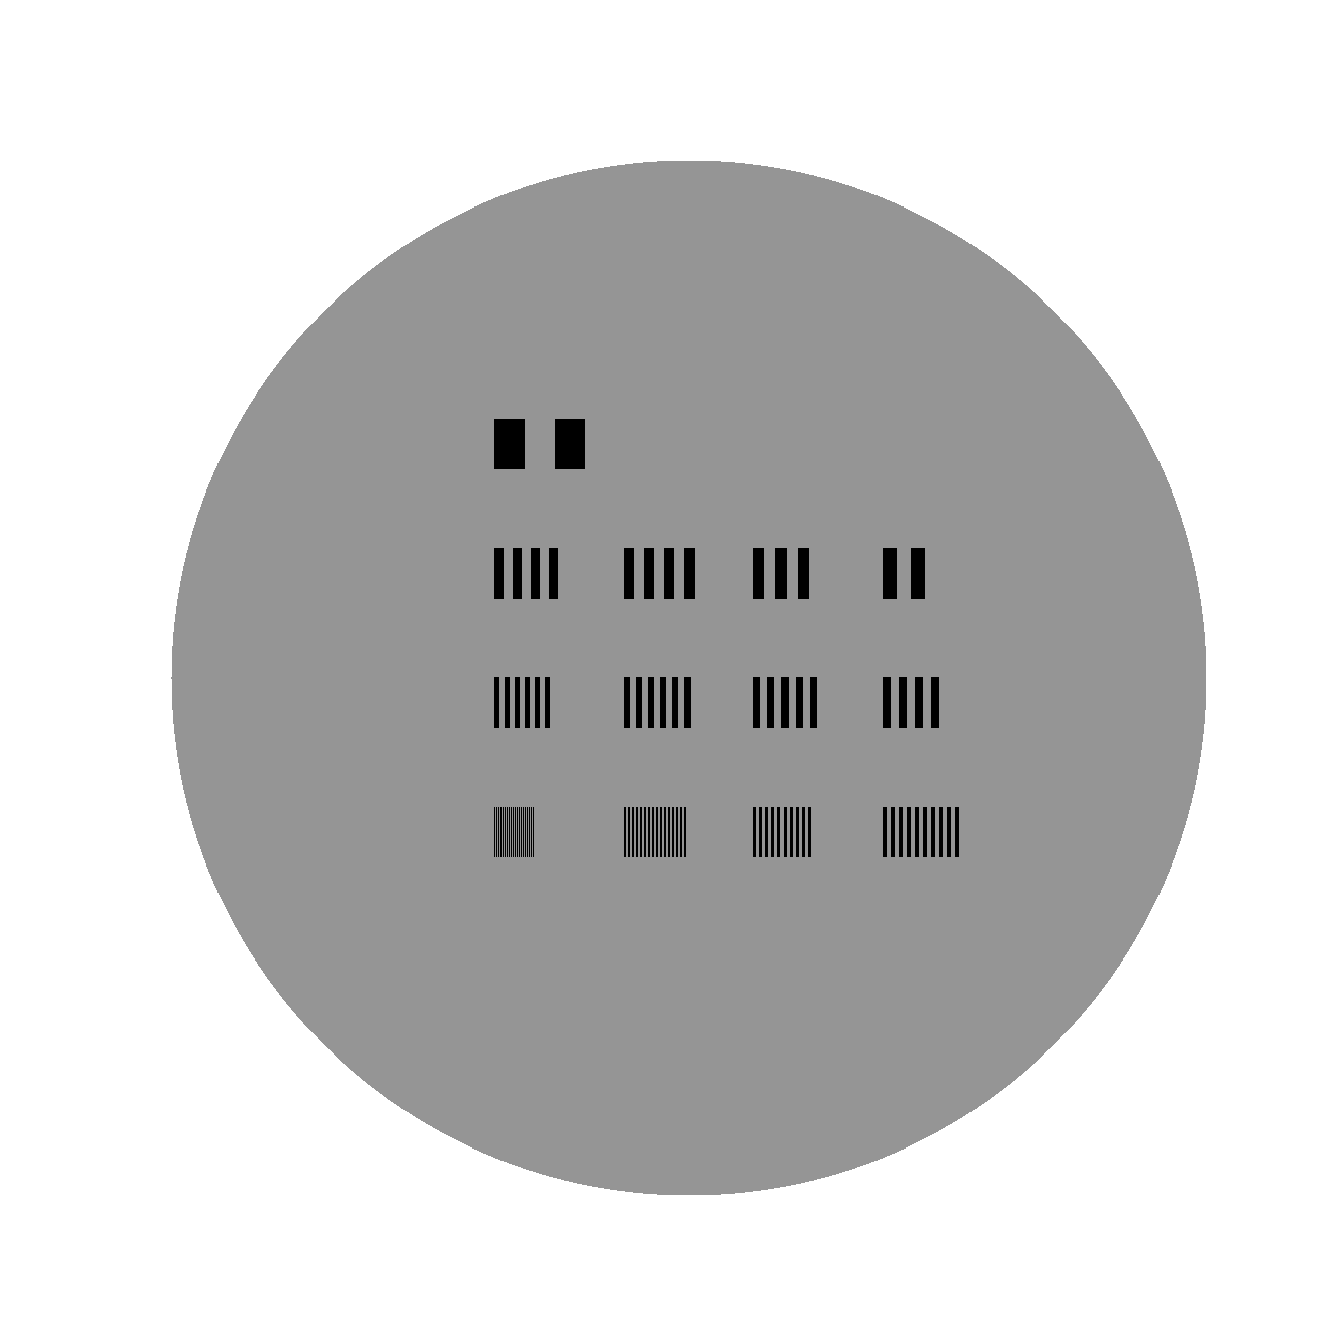

(-0.5, 1023.5, 1023.5, -0.5)

In [12]:
# im[im == 0] = -2
# im[im == 1] = -1
# im[im == 2] = 0
from matplotlib import colors

r,g,b,a = colors.to_rgba('cornflowerblue')
r2,g2,b2,a2 = colors.to_rgba('darkorange')


cdict2 = {'red':   ((0.0, 0.0, 0.0),
                   (0.5,r,r),
                   (1.0, r2, r2)),

         'green': ((0.0, 0.0, 0.0),
                   (0.5, g, g),
                   (1.0, g2, g2)),

         'blue':  ((0.0, 0.0, 0.0),
                   (0.5, b, b),
                   (1.0, b2, b2))
        }

from matplotlib.colors import LinearSegmentedColormap
blue_red1 = LinearSegmentedColormap('BlueRed1', cdict2)

plt.register_cmap(cmap=blue_red1)
cmap = plt.get_cmap('BlueRed1')

plt.figure(figsize=[5,5],dpi=300)
plt.imshow(im,cmap='Greys',interpolation='none')
plt.xticks([])
plt.yticks([])
plt.axis('off')


In [47]:
 import colorsys
colorsys.rgb_to_hsv(218/255,165/255,32/255)

(0.11917562724014337, 0.8532110091743119, 0.8549019607843137)

In [236]:
plt.savefig('MTF_phantom')

In [199]:
im_stack = np.tile(im,[10,1,1])

In [200]:
np.save('Contrast_phantom_1024',im_stack)

In [201]:
!mv Contrast_phantom_1024.npy ../xpecgen/data/phantoms/MTF_phantom_1024.npy

### Testing out an analysis module

In [229]:
MTF_loaded = np.load('/home/xcite/fastCAT/xpecgen/data/projs/MTF_recon_360.npy')

<IPython.core.display.Javascript object>


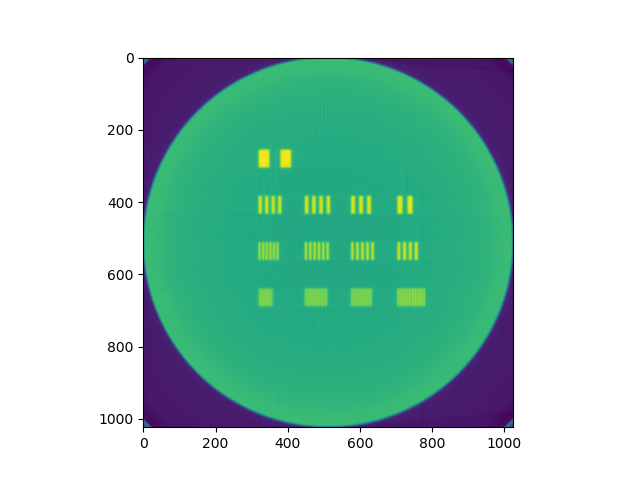

In [237]:
sh(MTF_loaded[5])

In [238]:
plt.savefig('MTF_recon')

In [256]:
slc = MTF_loaded[5]

In [257]:
slc[start_y:start_y+chunk_y,start_x:start_x+chunk_x]

array([[0.05919441, 0.05913079, 0.05911767, ..., 0.05833232, 0.05855439,
        0.05882866],
       [0.05929314, 0.05928394, 0.05925082, ..., 0.05820629, 0.05828734,
        0.05861406],
       [0.05930595, 0.05927008, 0.05923504, ..., 0.05817708, 0.05812832,
        0.05837213],
       ...,
       [0.0590469 , 0.05895729, 0.05887426, ..., 0.05808549, 0.05805792,
        0.05816985],
       [0.05901232, 0.05885936, 0.05881348, ..., 0.05822267, 0.05820298,
        0.05817708],
       [0.05912503, 0.05893668, 0.05887298, ..., 0.05831042, 0.05819499,
        0.05818876]], dtype=float32)

In [ ]:
chunk_x = 100
chunk_y = 35

signal = []

def get_diff(smoothed_slice):
    

        peak_info = sig.find_peaks(smoothed_slice,height=0.07,prominence=0.005)
        
        peaks = peak_info[0]
        valleys = np.unique(np.hstack([peak_info[1]['right_bases'],peak_info[1]['left_bases']]))
        
        inds = np.array(valleys < np.max(peaks)) * np.array(valleys > np.min(peaks))
        
        valleys = valleys[inds]
        peaks = peaks[:-1]
        
        diffs = []
        
        for peak, valley in zip(peaks, valleys):
            
            diff = smoothed_slice[peak] - smoothed_slice[valley]
            
            diffs.append(diff)
        
        return diffs

start_x = 310
start_y = 270

smoothed_slice = np.convolve(np.mean(slc[start_y:start_y+chunk_y,start_x:start_x+chunk_x],0),10*[0.1],'same')

signal.append(np.mean(get_diff(smoothed_slice)))

for start_y in [390,520,650]:
    for start_x in [690, 570, 430, 300]: 
        
        smoothed_slice = np.mean(slc[start_y:start_y+chunk_y,start_x:start_x+chunk_x],0)
        
        diffs = get_diff(smoothed_slice)
        
        if len(diffs) != 0:
            signal.append(np.mean(diffs))
        else:
            signal.append(0)
            break
        

<IPython.core.display.Javascript object>


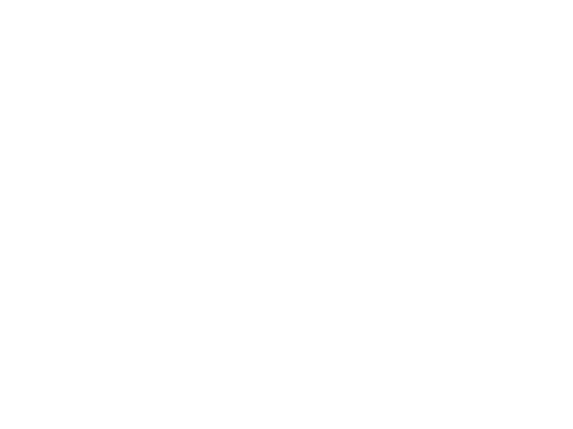

IndexError: list index out of range

In [3]:
pitch = 0.015625

lpmm = [1/(2*ii*pitch) for ii in range(12,0,-1)]

lpmm.insert(0,1/(2*30*pitch))

plt.figure()
plt.plot(lpmm[:len(signal)],signal/signal[0],'kx')
plt.plot(lpmm[:len(signal)],signal/signal[0])
plt.xlabel('lp/cm');plt.ylim([0,1.1])
plt.ylabel('MTF')

In [241]:
plt.savefig('MTF_lumpy')

In [228]:
chunk_x = 100
chunk_y = 10

signal = []

def get_diff(smoothed_slice):
    

        peak_info = sig.find_peaks(smoothed_slice,height=0.07,prominence=0.005)
        
        peaks = peak_info[0]
        valleys = np.unique(np.hstack([peak_info[1]['right_bases'],peak_info[1]['left_bases']]))
        
        inds = np.array(valleys < np.max(peaks)) * np.array(valleys > np.min(peaks))
        
        valleys = valleys[inds]
        peaks = peaks[:-1]
        
        diffs = []
        
        for peak, valley in zip(peaks, valleys):
            
            diff = smoothed_slice[peak] - smoothed_slice[valley]
            
            diffs.append(diff)
        
        return diffs

start_x = 310
start_y = 270

smoothed_slice = np.convolve(np.mean(slc[start_y:start_y+chunk_y,start_x:start_x+chunk_x],0),10*[0.1],'same')

signal.append(np.mean(get_diff(smoothed_slice)))

for start_y in np.array([400,520,650])+30:
    for start_x in [690, 570, 430, 300]: 
        
        smoothed_slice = np.mean(slc[start_y:start_y+chunk_y,start_x:start_x+chunk_x],0)
        
        diffs = get_diff(smoothed_slice)
        
        if len(diffs) != 0:
            signal.append(np.mean(diffs))
        else:
            signal.append(0)
            break
        
        
#         plt.figure()
#         plt.plot(smoothed_slice)
#         plt.plot(peaks,smoothed_slice[peaks],'rx')
#         plt.plot(valleys,smoothed_slice[valleys],'yx')

pitch = 0.015625

lpmm = [1/(2*ii*pitch) for ii in range(12,0,-1)]

lpmm.insert(0,1/(2*30*pitch))


plt.plot(lpmm[:len(signal)],signal/signal[0],'kx')
plt.plot(lpmm[:len(signal)],signal/signal[0])
plt.xlabel('lp/cm')
plt.ylabel('MTF')

Text(42.722222222222214, 0.5, 'MTF')

In [135]:
start = 300
stop = 400

smoothed_slice = np.mean(slc[660:680,start:stop],0)

<IPython.core.display.Javascript object>


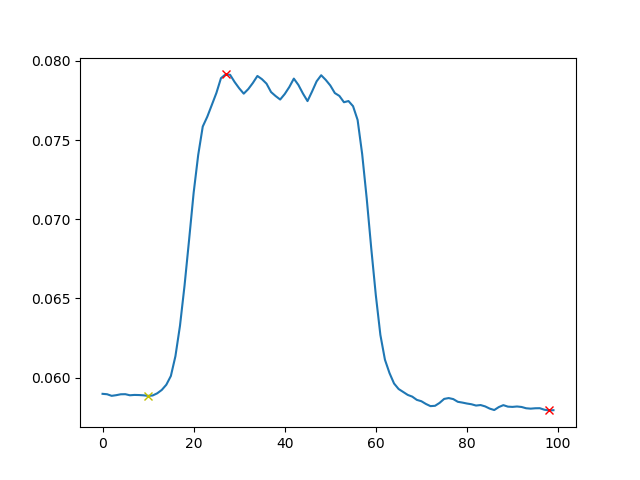

In [136]:
peak_info = sig.find_peaks(smoothed_slice,height=0.07,prominence=0.005)

plt.figure()
plt.plot(smoothed_slice)
plt.plot(peak_info[0],peak_info[1]['peak_heights'],'rx')
plt.plot(peak_info[1]['right_bases'],smoothed_slice[peak_info[1]['right_bases']],'rx')
plt.plot(peak_info[1]['left_bases'],smoothed_slice[peak_info[1]['left_bases']],'yx')

<IPython.core.display.Javascript object>


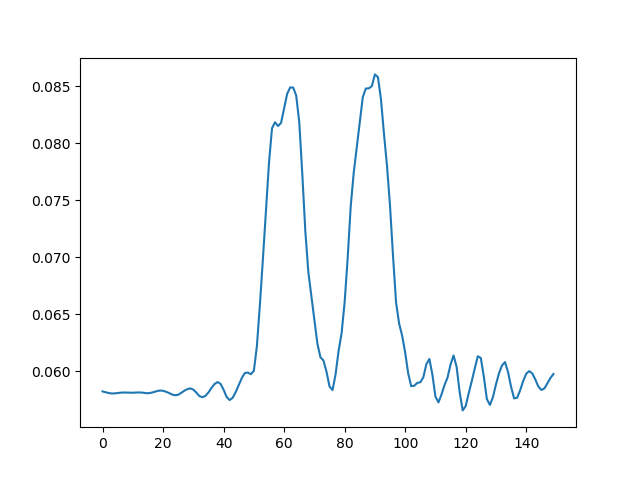

In [117]:
start = 650
stop = 800

smoothed_slice = np.mean(slc[400:450,start:stop],0)

peaks = smoothed_slice > 0.070

first = np.argmax(peaks)
last = np.argmax(peaks[-1::-1])

# smoothed_slice[:first] = 0
# smoothed_slice[-last:] = 0

plt.figure()
plt.plot(smoothed_slice)

In [110]:
import scipy.signal as sig

<IPython.core.display.Javascript object>


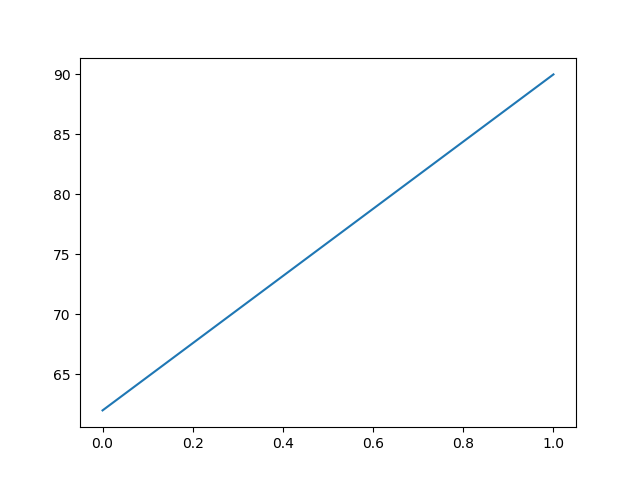

In [118]:
plt.figure()
plt.plot(sig.find_peaks(smoothed_slice,height=0.07,prominence=0.005)[0])

<IPython.core.display.Javascript object>


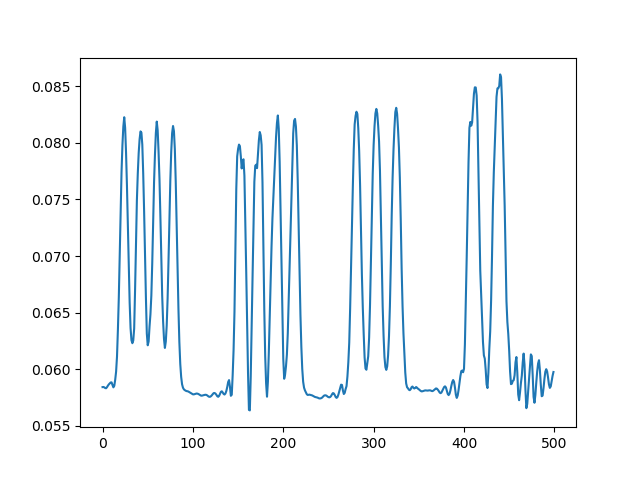

In [100]:
slc = MTF_loaded[5]

start = 300
stop = 800

plt.figure()
plt.plot(np.mean(slc[400:450,start:stop],0))
# plt.plot(np.diff(slc[530,start:stop]))
# plt.plot(np.diff(slc[650,start:stop]))

<IPython.core.display.Javascript object>


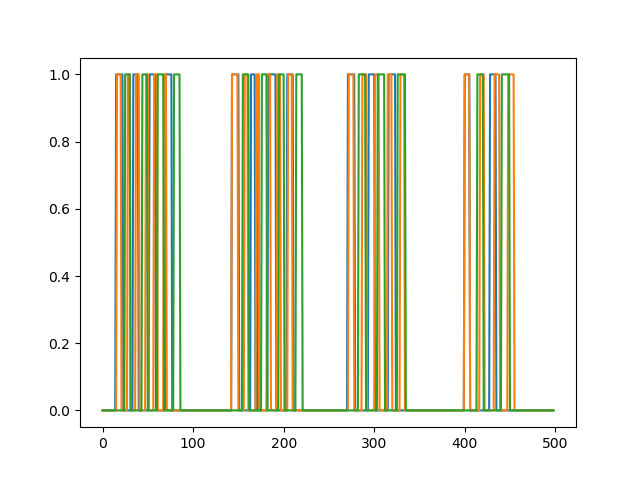

In [73]:
plt.figure()
plt.plot(np.diff(slc[400,start:stop])>0.002)
plt.plot(np.diff(slc[530,start:stop])>0.002)

<IPython.core.display.Javascript object>


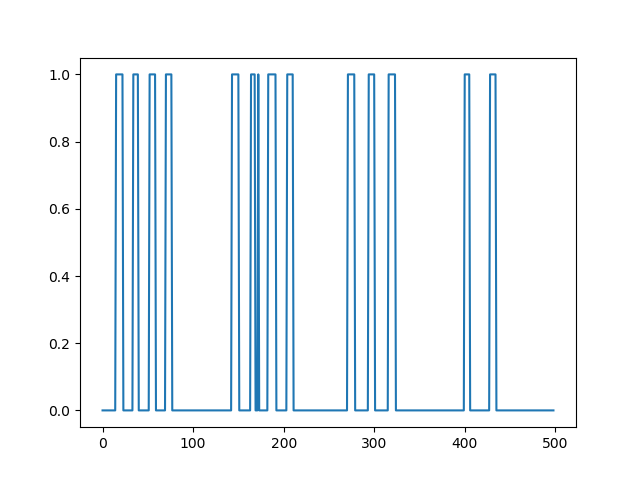

In [96]:
plt.figure()
plt.plot(np.diff(slc[400,start:stop])>0.002)

In [ ]:
tigre.algorithms.FDK()